#### Summary:
In this notebook I will make 2 new DL CNN models based on active enhancers: one for homeostatic KCs (based on peaks from control C57 KCs) and one for differential peaks in NASH (based on peaks specific for AMLN C57 KCs, with control peaks as background). For the second model I will also adjust the partitioning of data to maximize the amount of data in the training set, by getting rid of a testing set.

In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
from collections import Counter
import sys
import random
import os
import fnmatch
import sys

#both of these can be imported to python in the terminal in zs-deeplift env
from Bio import SeqIO
from Bio.Seq import Seq

In [2]:
dataDirectory = '/home/h1bennet/strains/data/ATAC/control_cohort2/'
workingDirectory = '/home/h1bennet//strains_machinelearning/results/00_New_ATAC_H3K27Ac_Model/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)


# prepare data

In [3]:
def load_genome(ref_path):
    ref_dict = {}
    for seq in SeqIO.parse(ref_path, "fasta"):
        chromID = seq.id
        chromSeq = (str(seq.seq)).upper()
        ref_dict[chromID] = chromSeq
    return ref_dict

In [4]:
ref_path = "/home/zes017/genomes/mm10/mm10.fa"
genomes = load_genome(ref_path)

### BED/peak file

In [5]:
def data_prep(path, genomes, label, size=500, rep=1, shift=None):
    print ("Scaled to %d" % (size))
    if shift is None:
        shifts = size//rep*np.arange(-rep//2+1,rep//2+1)
    elif type(shift) is int:
        shifts = np.abs(shift)*np.arange(-rep//2+1,rep//2+1)
    elif type(shift) is list:
        if len(shift) != rep:
            raise TypeError("Number of shift unequal to replicates")
        shifts = np.array(shift)
    if rep == 1 and shift is not None:
        random_shift = True
        print("Random shifting within %s" % (str(-np.abs(shift))+'~'+str(np.abs(shift))))
    else:
        random_shift = False
        print("Generate replicates by shifting %s bp" % (','.join(shifts.astype(str))))
    
    data_list = []
    for line in open(path):
        elems = line.split()
        chromID = elems[0]
        start, end = int(elems[1]), int(elems[2])
        length = end-start
        mid = (start+end)//2
        for s in shifts:
            if random_shift:
                new_mid = mid + np.random.choice(np.arange(-np.abs(shift), np.abs(shift)+1))
            else:
                new_mid = mid + s
            start = new_mid - size//2
            end = new_mid + size//2
            seq = genomes[chromID][start:end]
            if len(seq) != size:
                continue
            data_point = (seq, label, chromID, start, end)
            data_list.append(data_point)
    return data_list

In [6]:
# poised model
pos_data_path = "/home/h1bennet/strains_machinelearning/results/00_New_ATAC_H3K27Ac_Model/bed_files/poised_enhancers.bed"
pos_data_poised = data_prep(pos_data_path, genomes, 1, size=300, rep=1, shift=None)
neg_data_path = "/home/h1bennet/strains_machinelearning/results/00_New_ATAC_H3K27Ac_Model/bg_files/poised_enhancersbg.bed"
neg_data_poised = data_prep(neg_data_path, genomes, 0, size=300, rep=1, shift=None)

print(len(pos_data_poised), len(neg_data_poised))

Scaled to 300
Generate replicates by shifting 0 bp
Scaled to 300
Generate replicates by shifting 0 bp
37141 37141


In [7]:
# active model
pos_data_active_path = "/home/h1bennet/strains_machinelearning/results/00_New_ATAC_H3K27Ac_Model/bed_files/active_enhancers.bed"
pos_data_active = data_prep(pos_data_active_path, genomes, 1, size=300, rep=1, shift=None)
neg_data_active_path = "/home/h1bennet/strains_machinelearning/results/00_New_ATAC_H3K27Ac_Model/bg_files/active_enhancersbg.bed"
neg_data_active = data_prep(neg_data_active_path, genomes, 0, size=300, rep=1, shift=None)

print(len(pos_data_active), len(neg_data_active))

Scaled to 300
Generate replicates by shifting 0 bp
Scaled to 300
Generate replicates by shifting 0 bp
36151 36151


In [8]:
def create_dataset(dataset, train, valid, test):
    for data_point in dataset:
        chromID = data_point[2]
        if chromID == "chr8":
            valid.append(data_point)
        elif chromID == "chr9":
            test.append(data_point)
        else:
            train.append(data_point)

#version that eliminates the test set
def create_dataset2(dataset, train, valid):
    for data_point in dataset:
        chromID = data_point[2]
        if chromID == "chr8":
            valid.append(data_point)
#         elif chromID == "chr9":
#             test.append(data_point) #just take this out?
        else:
            train.append(data_point)
            
def dataset2onehot(dataset, shuffle=True):
    nucleotides = ["A", "T", "C", "G"]
    def seq2onehot(seq):
        onehot_list = []
        for nuc in seq:
            if nuc == "N":
                onehot = [0.25 for _ in range(len(nucleotides))]
                onehot_list.append(onehot)
            else:
                onehot = [0 for _ in range(len(nucleotides))]
                onehot[nucleotides.index(nuc)] = 1
                onehot_list.append(onehot)
        return onehot_list
    
    def rc(seq):
        return str((Seq(seq)).reverse_complement())
    
    onehot_dataset = []
    for (seq, label, chromID, start, end) in dataset:
        onehot_dataset.append((seq2onehot(seq), label, (chromID, start, end, "+")))
        onehot_dataset.append((seq2onehot(rc(seq)), label, (chromID, start, end, "-")))
    
    if shuffle:
        random.shuffle(onehot_dataset)
    
    x_list, y_list, info_list = [], [], [] 
    for (x, y, info) in onehot_dataset:
        x_list.append(x)
        y_list.append(y)
        info_list.append(info)
    return np.array(x_list), np.array(y_list), info_list

In [9]:
#poised
train_raw, valid_raw, test_raw = [], [], []
create_dataset(pos_data_poised, train_raw, valid_raw, test_raw)
create_dataset(neg_data_poised, train_raw, valid_raw, test_raw)
x_train, y_train, info_train = dataset2onehot(train_raw)
x_valid, y_valid, info_valid = dataset2onehot(valid_raw)
x_test, y_test, info_test = dataset2onehot(test_raw)

In [10]:
print('Training set:')
print(x_train.shape)
print(y_train.shape)
print('Validation set:')
print(x_valid.shape)
print(y_valid.shape)
print('Testing set:')
print(x_test.shape)
print(y_test.shape)

Training set:
(133490, 300, 4)
(133490,)
Validation set:
(7454, 300, 4)
(7454,)
Testing set:
(7620, 300, 4)
(7620,)


In [11]:
#active
train_raw_active, valid_raw_active, test_raw_active = [], [], []
create_dataset(pos_data_active, train_raw_active, valid_raw_active, test_raw_active)
create_dataset(neg_data_active, train_raw_active, valid_raw_active, test_raw_active)
x_train_active, y_train_active, info_train_active = dataset2onehot(train_raw_active)
x_valid_active, y_valid_active, info_valid_active = dataset2onehot(valid_raw_active)
x_test_active, y_test_active, info_test_active = dataset2onehot(test_raw_active)

In [12]:
print('Training set:')
print(x_train_active.shape)
print(y_train_active.shape)
print('Validation set:')
print(x_valid_active.shape)
print(x_valid_active.shape)
print('Testing set:')
print(x_test_active.shape)
print(y_test_active.shape)

Training set:
(130154, 300, 4)
(130154,)
Validation set:
(7164, 300, 4)
(7164, 300, 4)
Testing set:
(7286, 300, 4)
(7286,)


# Construct the model

In [13]:
# Train model in keras
#
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
import tensorflow.keras.backend as K

Using TensorFlow backend.


In [14]:
batch_size = 128
num_classes = 1
seq_size = 300
n_channels = 4
input_shape = (seq_size, n_channels)

# Poised Enhancers

In [15]:
# model structure
model = Sequential()
# conv1
model.add(Conv1D(320, kernel_size=8, strides=1, padding='valid',
    kernel_initializer=keras.initializers.TruncatedNormal(stddev=1e-2),
    kernel_regularizer=keras.regularizers.l2(5e-7),
    bias_initializer=keras.initializers.Constant(value=0),
    activity_regularizer=keras.regularizers.l1(1e-8),
    input_shape=input_shape, name='conv1'))
model.add(BatchNormalization(name = "bn1"))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=4, strides=4, padding='same'))
model.add(Dropout(0.2))

# conv2
model.add(Conv1D(480, kernel_size=8, strides=1, padding='valid',
    kernel_initializer=keras.initializers.TruncatedNormal(stddev=1e-2),
    kernel_regularizer=keras.regularizers.l2(5e-7),
    bias_initializer=keras.initializers.Constant(value=0),
    activity_regularizer=keras.regularizers.l1(1e-8),
    name='conv2'))
model.add(BatchNormalization(name = "bn2"))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=4, strides=4, padding='same'))
model.add(Dropout(0.2))

# conv3
model.add(Conv1D(960, kernel_size=8, strides=1, padding='valid',
    kernel_initializer=keras.initializers.TruncatedNormal(stddev=1e-2),
    kernel_regularizer=keras.regularizers.l2(5e-7),
    bias_initializer=keras.initializers.Constant(value=0),
    activity_regularizer=keras.regularizers.l1(1e-8),
    name='conv3'))
model.add(BatchNormalization(name = "bn3"))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Flatten())

# fc1
model.add(Dense(925,
    kernel_initializer=keras.initializers.TruncatedNormal(stddev=1e-2),
    kernel_regularizer=keras.regularizers.l2(5e-7),
    bias_initializer=keras.initializers.Constant(value=0),
    activity_regularizer=keras.regularizers.l1(1e-8)))
model.add(Activation('relu'))

# output
model.add(Dense(num_classes,
    kernel_initializer=keras.initializers.TruncatedNormal(stddev=1e-2),
    kernel_regularizer=keras.regularizers.l2(5e-7),
    bias_initializer=keras.initializers.Constant(value=0),
    activity_regularizer=keras.regularizers.l1(1e-8)))
model.add(Activation('sigmoid'))
# end

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [16]:
import tensorflow as tf
def load_from_tf(name):
    return tf.train.load_variable("/home/zes017/AD/data/AgentBind/benchmarking_dnase/data/model", name=name)

In [17]:
model.get_layer("conv1").set_weights(
    [load_from_tf('conv1/weights/ExponentialMovingAverage'),
    load_from_tf('conv1/biases/ExponentialMovingAverage')])
model.get_layer("conv2").set_weights(
    [load_from_tf('conv2/weights/ExponentialMovingAverage'),
    load_from_tf('conv2/biases/ExponentialMovingAverage')])
model.get_layer("conv3").set_weights(
    [load_from_tf('conv3/weights/ExponentialMovingAverage'),
    load_from_tf('conv3/biases/ExponentialMovingAverage')])
model.get_layer("bn1").set_weights(
    [load_from_tf('conv1/batch_normalization/gamma/ExponentialMovingAverage'),
     load_from_tf('conv1/batch_normalization/beta/ExponentialMovingAverage'),
    np.zeros(model.get_layer("bn1").weights[2].shape),
    np.zeros(model.get_layer("bn1").weights[3].shape)])
model.get_layer("bn2").set_weights(
    [load_from_tf('conv2/batch_normalization/gamma/ExponentialMovingAverage'),
     load_from_tf('conv2/batch_normalization/beta/ExponentialMovingAverage'),
    np.zeros(model.get_layer("bn2").weights[2].shape),
    np.zeros(model.get_layer("bn2").weights[3].shape)])
model.get_layer("bn3").set_weights(
    [load_from_tf('conv3/batch_normalization/gamma/ExponentialMovingAverage'),
     load_from_tf('conv3/batch_normalization/beta/ExponentialMovingAverage'),
    np.zeros(model.get_layer("bn3").weights[2].shape),
    np.zeros(model.get_layer("bn3").weights[3].shape)])

# Active Enhancer Model (model2)

In [18]:
# model structure (same as prev, but second making a second model)
model2 = Sequential()
# conv1
model2.add(Conv1D(320, kernel_size=8, strides=1, padding='valid',
    kernel_initializer=keras.initializers.TruncatedNormal(stddev=1e-2),
    kernel_regularizer=keras.regularizers.l2(5e-7),
    bias_initializer=keras.initializers.Constant(value=0),
    activity_regularizer=keras.regularizers.l1(1e-8),
    input_shape=input_shape, name='conv1'))
model2.add(BatchNormalization(name = "bn1"))
model2.add(Activation('relu'))
model2.add(MaxPooling1D(pool_size=4, strides=4, padding='same'))
model2.add(Dropout(0.2))

# conv2
model2.add(Conv1D(480, kernel_size=8, strides=1, padding='valid',
    kernel_initializer=keras.initializers.TruncatedNormal(stddev=1e-2),
    kernel_regularizer=keras.regularizers.l2(5e-7),
    bias_initializer=keras.initializers.Constant(value=0),
    activity_regularizer=keras.regularizers.l1(1e-8),
    name='conv2'))
model2.add(BatchNormalization(name = "bn2"))
model2.add(Activation('relu'))
model2.add(MaxPooling1D(pool_size=4, strides=4, padding='same'))
model2.add(Dropout(0.2))

# conv3
model2.add(Conv1D(960, kernel_size=8, strides=1, padding='valid',
    kernel_initializer=keras.initializers.TruncatedNormal(stddev=1e-2),
    kernel_regularizer=keras.regularizers.l2(5e-7),
    bias_initializer=keras.initializers.Constant(value=0),
    activity_regularizer=keras.regularizers.l1(1e-8),
    name='conv3'))
model2.add(BatchNormalization(name = "bn3"))
model2.add(Activation('relu'))
model2.add(Dropout(0.5))

model2.add(Flatten())

# fc1
model2.add(Dense(925,
    kernel_initializer=keras.initializers.TruncatedNormal(stddev=1e-2),
    kernel_regularizer=keras.regularizers.l2(5e-7),
    bias_initializer=keras.initializers.Constant(value=0),
    activity_regularizer=keras.regularizers.l1(1e-8)))
model2.add(Activation('relu'))

# output
model2.add(Dense(num_classes,
    kernel_initializer=keras.initializers.TruncatedNormal(stddev=1e-2),
    kernel_regularizer=keras.regularizers.l2(5e-7),
    bias_initializer=keras.initializers.Constant(value=0),
    activity_regularizer=keras.regularizers.l1(1e-8)))
model2.add(Activation('sigmoid'))
# end

In [19]:
import tensorflow as tf
def load_from_tf(name):
    return tf.train.load_variable("/home/zes017/AD/data/AgentBind/benchmarking_dnase/data/model", name=name)

In [20]:
model2.get_layer("conv1").set_weights(
    [load_from_tf('conv1/weights/ExponentialMovingAverage'),
    load_from_tf('conv1/biases/ExponentialMovingAverage')])
model2.get_layer("conv2").set_weights(
    [load_from_tf('conv2/weights/ExponentialMovingAverage'),
    load_from_tf('conv2/biases/ExponentialMovingAverage')])
model2.get_layer("conv3").set_weights(
    [load_from_tf('conv3/weights/ExponentialMovingAverage'),
    load_from_tf('conv3/biases/ExponentialMovingAverage')])
model2.get_layer("bn1").set_weights(
    [load_from_tf('conv1/batch_normalization/gamma/ExponentialMovingAverage'),
     load_from_tf('conv1/batch_normalization/beta/ExponentialMovingAverage'),
    np.zeros(model2.get_layer("bn1").weights[2].shape),
    np.zeros(model2.get_layer("bn1").weights[3].shape)])
model2.get_layer("bn2").set_weights(
    [load_from_tf('conv2/batch_normalization/gamma/ExponentialMovingAverage'),
     load_from_tf('conv2/batch_normalization/beta/ExponentialMovingAverage'),
    np.zeros(model2.get_layer("bn2").weights[2].shape),
    np.zeros(model2.get_layer("bn2").weights[3].shape)])
model2.get_layer("bn3").set_weights(
    [load_from_tf('conv3/batch_normalization/gamma/ExponentialMovingAverage'),
     load_from_tf('conv3/batch_normalization/beta/ExponentialMovingAverage'),
    np.zeros(model2.get_layer("bn3").weights[2].shape),
    np.zeros(model2.get_layer("bn3").weights[3].shape)])

# Train the model

In [21]:
if not os.path.isdir('./model_weights/'):
    os.mkdir('./model_weights/')

# Poised
Set names: x_train, y_train, x_valid, y_valid, x_test, y_test

In [22]:
model.compile(loss=keras.losses.binary_crossentropy,
        optimizer=keras.optimizers.Adam(lr=1e-2),
        metrics=['accuracy'])

history = model.fit(x=x_train, y=y_train,
            batch_size=batch_size,
            epochs=20,
            verbose=1,
            validation_data=(x_valid, y_valid))
score = model.evaluate(x_test_active, y_test_active, verbose=0, batch_size=batch_size)
print('\nhistory dict:', history.history)
print(score)

keras_model_weights = workingDirectory+"/model_weights/modelWeights_300bp_C57BL6J_poised_epo20_RandomShift0bp.h5"
keras_model_json = workingDirectory+"/model_weights/modelWeights_300bp_C57BL6J_poised_epo20_RandomShift0bp.json"

json_string = model.to_json() # architecture
with open(keras_model_json, 'w') as json_file:
    json_file.write(json_string)
model.save_weights(keras_model_weights) # weights

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 133490 samples, validate on 7454 samples
Epoch 1/20
133490/133490 [==============================] - 439s 3ms/step - loss: 0.5975 - accuracy: 0.8312 - val_loss: 0.5048 - val_accuracy: 0.8640
Epoch 2/20
133490/133490 [==============================] - 438s 3ms/step - loss: 0.5392 - accuracy: 0.8442 - val_loss: 0.4790 - val_accuracy: 0.8658
Epoch 3/20
133490/133490 [==============================] - 438s 3ms/step - loss: 0.4945 - accuracy: 0.8513 - val_loss: 0.4768 - val_accuracy: 0.8575
Epoch 4/20
133490/133490 [==============================] - 441s 3ms/step - loss: 0.4728 - accuracy: 0.8554 - val_loss: 0.4369 - val_accuracy: 0.8731
Epoch 5/20
133490/133490 [==============================] - 440s 3ms/step - loss: 0.4638 - accuracy: 0.8563 - val_loss: 0.4263 - val_accuracy: 0.8728
Epoch 6/20
133490/133490 [==============================] - 440s 3ms/step - loss: 0.4551 - accuracy: 0.85

In [23]:
##Load model
from keras.models import model_from_json

model_weights = workingDirectory+"/model_weights/modelWeights_300bp_C57BL6J_poised_epo20_RandomShift0bp.h5"
model_json = workingDirectory+"/model_weights/modelWeights_300bp_C57BL6J_poised_epo20_RandomShift0bp.json"

model = model_from_json(open(model_json).read())
model.load_weights(model_weights)
model.compile(loss=keras.losses.binary_crossentropy,
        optimizer=keras.optimizers.Adam(lr=1e-2),
        metrics=['accuracy'])
# model.evaluate(x_test, y_test, batch_size=batch_size)
preds = model.predict(x_test).flatten()

from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds, pos_label=1)
print('AUC:', metrics.auc(fpr, tpr))
print('Accuracy:', metrics.accuracy_score(y_test, (preds>0.5)*1))

AUC: 0.9503915895061728
Accuracy: 0.8695538057742782


# Active
Set names: x_train_active, y_train_active, x_valid_active, y_valid_active, x_test_active, y_test_active

In [22]:
model2.compile(loss=keras.losses.binary_crossentropy,
        optimizer=keras.optimizers.Adam(lr=1e-2),
        metrics=['accuracy'])

history2 = model2.fit(x=x_train_active, y=y_train_active,
            batch_size=batch_size,
            epochs=20,
            verbose=1,
            validation_data=(x_valid_active, y_valid_active))

score2 = model2.evaluate(x_test_active, y_test_active, verbose=0, batch_size=batch_size)
print('\nhistory dict:', history2.history)
print(score2)

#instead saved here initially and then moved to ^ folder
keras_model_weights2 = workingDirectory+"/model_weights/modelWeights_300bp_C57BL6J_active_epo20_RandomShift0bp.h5"
keras_model_json2 = workingDirectory+"/model_weights/modelWeights_300bp_C57BL6J_active_epo20_RandomShift0bp.json"

json_string = model2.to_json() # architecture
with open(keras_model_json2, 'w') as json_file:
    json_file.write(json_string)
model2.save_weights(keras_model_weights2) # weights

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 130154 samples, validate on 7164 samples
Epoch 1/20
130154/130154 [==============================] - 417s 3ms/step - loss: 0.7184 - accuracy: 0.7689 - val_loss: 0.6860 - val_accuracy: 0.7824
Epoch 2/20
130154/130154 [==============================] - 416s 3ms/step - loss: 0.6568 - accuracy: 0.7804 - val_loss: 0.5870 - val_accuracy: 0.8058
Epoch 3/20
130154/130154 [==============================] - 415s 3ms/step - loss: 0.6072 - accuracy: 0.7877 - val_loss: 0.5613 - val_accuracy: 0.8054
Epoch 4/20
130154/130154 [==============================] - 414s 3ms/step - loss: 0.5782 - accuracy: 0.7914 - val_loss: 0.5356 - val_accuracy: 0.8116
Epoch 5/20
130154/130154 [==============================] - 416s 3ms/step - loss: 0.5562 - accuracy: 0.7956 - val_loss: 0.5287 - val_accuracy: 0.8051
Epoch 6/20
130154/130154 [==============================] - 415s 3ms/step - loss: 0.5451 - accuracy: 0.79

RuntimeError: You must compile a model before training/testing. Use `model.compile(optimizer, loss)`.

In [23]:
score2 = model2.evaluate(x_test_active, y_test_active, verbose=0, batch_size=batch_size)
print('\nhistory dict:', history2.history)
print(score2)

#instead saved here initially and then moved to ^ folder
keras_model_weights2 = workingDirectory+"/model_weights/modelWeights_300bp_C57BL6J_active_epo20_RandomShift0bp.h5"
keras_model_json2 = workingDirectory+"/model_weights/modelWeights_300bp_C57BL6J_active_epo20_RandomShift0bp.json"

json_string = model2.to_json() # architecture
with open(keras_model_json2, 'w') as json_file:
    json_file.write(json_string)
model2.save_weights(keras_model_weights2) # weights


history dict: {'val_loss': [0.6860448426204577, 0.5870248079632727, 0.5612665394509324, 0.5355781432239122, 0.528744388332186, 0.5321243085853219, 0.5265512655128786, 0.5181853470024884, 0.5023681396282564, 0.49987501739656903, 0.5012673253390059, 0.4890247217807472, 0.5096842930810802, 0.48638056330944424, 0.4856719158003278, 0.5107910407115334, 0.5127159621647654, 0.4919619049059486, 0.4787564926277919, 0.4876274098769571], 'val_accuracy': [0.7823841571807861, 0.8058347105979919, 0.8054159879684448, 0.8115577697753906, 0.8051367998123169, 0.7913177013397217, 0.804857611656189, 0.800949215888977, 0.8118369579315186, 0.8054159879684448, 0.8031826019287109, 0.8108598589897156, 0.803043007850647, 0.8105806708335876, 0.8109994530677795, 0.8008096218109131, 0.7922948002815247, 0.8049972057342529, 0.8149078488349915, 0.8070909976959229], 'loss': [0.718446445186285, 0.6568286399579945, 0.6072387490121287, 0.5781779678873521, 0.556217206640572, 0.5450509168238672, 0.5351680436285207, 0.52912

In [35]:
##Load model
from keras.models import model_from_json

model_active_weights = workingDirectory+"/model_weights/modelWeights_300bp_C57BL6J_active_epo20_RandomShift0bp.h5"
model_active_json = workingDirectory+"/model_weights/modelWeights_300bp_C57BL6J_active_epo20_RandomShift0bp.json"

model_active = model_from_json(open(model_active_json).read())
model_active.load_weights(model_active_weights)
model_active.compile(loss=keras.losses.binary_crossentropy,
        optimizer=keras.optimizers.Adam(lr=1e-2),
        metrics=['accuracy'])
# model_active.evaluate(x_test, y_test, batch_size=batch_size)
preds_active = model_active.predict(x_test_active).flatten()

from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test_active, preds_active, pos_label=1)
print('AUC:', metrics.auc(fpr, tpr))
print('Accuracy:', metrics.accuracy_score(y_test_active, (preds_active>0.5)*1))

AUC: 0.9019286253828798
Accuracy: 0.8140269009058468


Note from Zeyang: "Watch for the validation loss and training loss while you train the AMLN model. If the training loss keeps dropping while the validation loss becomes larger and larger, the model likely overfits."

# Plotting Loss and Validation Loss

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
print(history2.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


In [27]:
print(history2.history['val_loss'])

[0.6860448426204577, 0.5870248079632727, 0.5612665394509324, 0.5355781432239122, 0.528744388332186, 0.5321243085853219, 0.5265512655128786, 0.5181853470024884, 0.5023681396282564, 0.49987501739656903, 0.5012673253390059, 0.4890247217807472, 0.5096842930810802, 0.48638056330944424, 0.4856719158003278, 0.5107910407115334, 0.5127159621647654, 0.4919619049059486, 0.4787564926277919, 0.4876274098769571]


Text(0, 0.5, 'Loss')

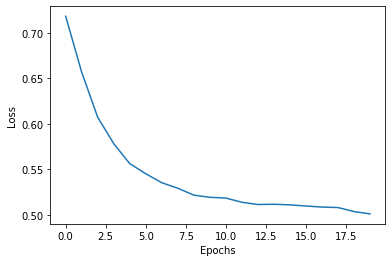

In [28]:
g = sns.lineplot(x=range(20),y=history2.history['loss'])
#g.set_ylabels("Survived")
#g.set_axis_labels("Epochs", "Validation Loss")
g.set_xlabel("Epochs")
g.set_ylabel("Loss")

Text(0, 0.5, 'Validation Loss')

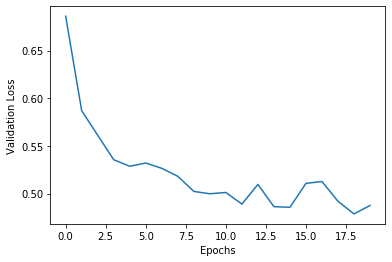

In [29]:
g = sns.lineplot(x=range(20),y=history2.history['val_loss'])
#g.set_ylabels("Survived")
#g.set_axis_labels("Epochs", "Validation Loss")
g.set_xlabel("Epochs")
g.set_ylabel("Validation Loss")

In [30]:
g = sns.lineplot(x=range(20),y=history.history['loss'])
#g.set_ylabels("Survived")
#g.set_axis_labels("Epochs", "Validation Loss")
g.set_xlabel("Epochs")
g.set_ylabel("Loss")

NameError: name 'history' is not defined

In [ ]:
g = sns.lineplot(x=range(20),y=history.history['val_loss'])
#g.set_ylabels("Survived")
#g.set_axis_labels("Epochs", "Validation Loss")
g.set_xlabel("Epochs")
g.set_ylabel("Validation Loss")